# Welcome to GA solutions to vacation problem.

To define your own parameter in the GA, please follow the cells below.

Set the variable `use_default` as false if different parameter are to be specified in this algorithm. 

Set it to `True` if the default values of all parameter are used, and immediately run all cells in this notebook.

In [0]:
use_default = False

Specify the absolute path to the pickled solutions in the variable `pickled_solution_path`

In [0]:
pickled_solution_path = '/content/drive/My Drive/ai-ga-algo/csp-solutions-compressed.pyfile'

Specify the days of travelling in the variable `days_of_travel_param`.

Specify the allocated budget in the variable `allocated_budget_param`.

In [0]:
days_of_travel_param = 4
allocated_budget_param = 2500

Specify the population size in the variable `population_size_param`.

Specify the number of iterations for the GA in the variable `number_of_evolutions_param`.

In [0]:
population_size_param = 500
number_of_evolutions_param = 50

Specify the percentage of fit population to retain in each iteration of evolution in the variable `retain_param`.

Specify the probability of mutation in the variable `radiation`.

In [0]:
radiation_param = 0.4
retain_param = 0.5

Set `verbose_param` to `True` to enable intermediate message in every iteration of GA evolution. Otherwise, set it to `False`.

Set `mutate_once_param` to `True` if the mutation probability is for mutation of all offspring at once. Set it to `False` if the mutation of each offspring is independent from each other. 

In [0]:
verbose_param = False
mutate_once_param = False

## End of Parameter Specification 
Setting of parameter is done. Please run all of the cells below at once.

# Genetic Algorithm to Solve Vacation Problem

In [0]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# loading from pickle
import pickle
import gzip

def dump_obj(obj, filename):
    with gzip.GzipFile(filename, 'wb') as f:
        pickle.dump(obj, f)

def load_obj(filename):
    obj = None
    with gzip.GzipFile(filename, 'rb') as f:
        obj = pickle.load(f)
    return obj

In [0]:
# mounting google drive
# from google.colab import drive
# drive.mount('/content/drive/')

In [0]:
# Load solutions from CSP
if use_default:
    path = '/content/drive/My Drive/ai-ga-algo/'
    solutions = load_obj(path + 'csp-solutions-compressed.pyfile')
else:
    solutions = load_obj(pickled_solution_path)

## Multi-hot Encoding

In [0]:
def add_choice(choices, **kwargs):
    index = 2 ** len(choices)
    choices[index] = kwargs
    #clear doubt here

def range_of_choices(choices):
    return range(sum(choices.keys()) + 1)
    #returns 2 ** len(choices)

def choose(choices, choice_number):
    power = len(choices)
    chosen_items = list()
 
    while choice_number > 0:
        if choice_number - 2**power >= 0:
            choice_number -= 2**power
            if 2**power in choices:
                chosen_items.append(choices[2**power])
        power -= 1
 
    return chosen_items

## Set up abbreviation and domain space

In [0]:
abbr = {
    'h': 'hotels',
    'f': 'food_types',
    't': 'tourist_spots',
    'r': 'transportations'
}

# To set up the domain space
hotels = list()
food_types = dict()
tourist_spots = dict()
transportations = dict()

In [0]:
# Add hotels, e.g.
hotels.append({
    "name": "Avani Sepang Goldcoast Resort",
    "star": 5,
    "ppn": 470
})
    
hotels.append({
    "name": "Shangri-La Hotel Kuala Lumpur",
    "star": 5,
    "ppn": 504
})

hotels.append({
    "name": "St. Giles Hotel & Residences",
    "star": 4,
    "ppn": 412
})

hotels.append({
    "name": "Sunway Pyramid Hotel",
    "star": 4,
    "ppn": 302
})
    
hotels.append({
    "name": "Sunway Velocity Hotel",
    "star": 3,
    "ppn": 241
})
    
hotels.append({
    "name": "THE FACE Suites",
    "star": 3,
    "ppn": 349
})

In [0]:
# Add tourist spot, e.g.

add_choice(
    tourist_spots,
    name = "Sunway Lagoon",
    price = 108
)

add_choice(
    tourist_spots,
    name = "ATV Adventure Park",
    price = 200
)

add_choice(
    tourist_spots,
    name = "Garden of Nature",
    price = 121
)

add_choice(
    tourist_spots,
    name = "Petronas Twin Towers",
    price = 122
)

add_choice(
    tourist_spots,
    name = "Paradise Park Farm",
    price = 63
)

In [0]:
# Add food type, e.g.
add_choice(
    food_types,
    type = "Chinese Food",
    price = range(20, 30)
)

add_choice(
    food_types,
    type = "Indian Banana Leaf",
    price = range(10, 20)
)

add_choice(
    food_types,
    type = "Western Food",
    price = range(20, 50)
)


add_choice(
    food_types,
    type = "Local Seafood",
    price = range(20, 30)
)


add_choice(
    food_types,
    type = "Malay Food",
    price = range(7, 20)
)

In [0]:
# Add transportations, e.g.
add_choice(
    transportations,
    name = "Kommuter",
    ppd = 6
)


add_choice(
    transportations,
    name = "RapidKL Bus",
    ppd = 6
)


add_choice(
    transportations,
    name = "LRT",
    ppd = 5
)


add_choice(
    transportations,
    name = "KLIA Express",
    ppd = 55
)


add_choice(
    transportations,
    name = "Taxi",
    ppd = 40
)

## Define fixed variable

In [0]:
# fixed variables
if use_default:
    days_of_travel = 4
    allocated_budget = 2500
else:
    days_of_travel = days_of_travel_param
    allocated_budget = allocated_budget_param

## Define range of choices for each domain

In [0]:
hotel_range = range(len(hotels))
food_type_range = range_of_choices(food_types)
tourist_spot_range = range_of_choices(tourist_spots)
transportation_range = range_of_choices(transportations)

## Deriving fitness function from total cost and total options

In [0]:
def total_cost_and_options(**k):
    h, t, f, r = k['h'], k['t'], k['f'], k['r']
    hotel_cost = hotels[h]["ppn"] * days_of_travel

    tourist_list = choose(tourist_spots, t)
    tourist_cost = sum([i['price'] for i in tourist_list])

    food_list = choose(food_types,f)
    food_cost = sum([(max(i['price'])+min(i['price'])) / 2 * days_of_travel for i in food_list]) 
    
    transportation_list = choose(transportations,r)
    transportation_cost = sum([i['ppd'] * days_of_travel for i in transportation_list])
        
    total_cost = hotel_cost + tourist_cost + food_cost + transportation_cost
    return total_cost, len(tourist_list) + len(food_list) + len(transportation_list)

def fitness_function(solution):
    cost, options=  total_cost_and_options(**solution)
    return cost/options

## Define function to sort population by fitness

In [0]:
def pair_population_fitness(population):
    return [(i, fitness_function(i)) for i in population]

def sort_by_fitness(population):
    population_fitness = pair_population_fitness(population)
    population_fitness = sorted(population_fitness, key=lambda x: x[1])
    population = [i[0] for i in population_fitness]
    return population

## Define function to obtain average fitness score in a population

In [0]:
def get_population_fitness(population):
    population_fitness = pair_population_fitness(population)
    population_fitness_average = np.mean([i[1] for i in population_fitness])
    return population_fitness_average

## Define crossbreed, mutate, and evolve function

In [0]:
def crossbreed(gene_a, gene_b):
    # select how many attributes to swap
    swaps = random.randint(1, 3)

    # select attributes to swap
    attr = random.sample(gene_a.keys(), swaps)

    copy_a, copy_b = dict(gene_a), dict(gene_b)

    # crossbreed
    for i in attr:
        copy_a[i], copy_b[i] = copy_b[i], copy_a[i]

    if copy_a == gene_a or copy_b == gene_b:
        raise Exception("Same breed is generated.")

    return copy_a, copy_b
  
def mutate(gene):
    # select with attribute to mutate
    attr = random.choice(list(gene.keys()))
    if attr == "h":
        gene[attr] = random.choice(hotel_range)
    elif attr == "f":
        gene[attr] = random.choice(food_type_range)
    elif attr == "t":
        gene[attr] = random.choice(tourist_spot_range)
    else:
        gene[attr] = random.choice(transportation_range)
    return gene

def evolve(pop, target, retain, radiation, mutate_once, verbose):
    pop = sort_by_fitness(pop)
    retain = int(len(pop) * retain)
    new_pop = pop[:retain]
    if verbose:
        print("Removed", len(pop) - retain)

    collision = 0
    mutation = 0
    disqualified = 0
    while(len(new_pop) < target):
        gene_a, gene_b = random.sample(pop, 2)
        try:
            gene_c, gene_d = crossbreed(gene_a=gene_a, gene_b=gene_b)

            if(random.random() < radiation):
                if mutate_once:
                    mutation += 2
                    gene_c, gene_d = mutate(gene_c), mutate(gene_d)
                else:
                    mutation += 1
                    gene_c = mutate(gene_c)
                    if(random.random() < radiation):
                        gene_d = mutate(gene_d)
                        mutation += 1

            if gene_c in new_pop or gene_d in new_pop:
                # only append unique gene
                  collision += 1
                  if gene_c in new_pop and gene_d in new_pop:
                      # both genes are collisions and should be considered 
                      # as extra demerit
                      collision += 1
                  continue

            if total_cost_and_options(**gene_c)[0] > allocated_budget:
                disqualified += 1
            else:
                new_pop.append(gene_c)

            if total_cost_and_options(**gene_d)[0] > allocated_budget:
                disqualified += 1
            else:
                new_pop.append(gene_d)

        except:
            # collision with parents aka same gene result with parents
            collision += 1

    if verbose:
        print("Number of collisions:", collision)
        print("Number of mutations:", mutation)
        print("Number of disqualified:", disqualified)
    return new_pop

##  Define evolution iteration parameter

In [0]:
if use_default:
    population_size = 500
    number_of_evolutions = 50
    retain = 0.5
    radiation = 0.4
    mutate_once = False
    verbose = False
else:
    population_size = population_size_param
    number_of_evolutions = number_of_evolutions_param
    retain = retain_param
    radiation = radiation_param
    mutate_once = mutate_once_param
    verbose = verbose_param

## Perform GA iteration

In [0]:
population = random.sample(solutions, population_size)
evolution_history = list()
average_cost_and_options = [total_cost_and_options(**i) for i in population]
average_cost = np.mean([i[0] for i in average_cost_and_options])
average_options = np.mean([i[1] for i in average_cost_and_options])
evolution_history.append([get_population_fitness(population), average_cost, average_options])

for i in range(1, number_of_evolutions):
    # perform one evoluation
    new_population = evolve(population, population_size, retain, radiation, mutate_once, verbose)

    # get the fitness score of the new population
    fitness = get_population_fitness(new_population)

    # get the average spending and options in the new population
    average_cost_and_options = [total_cost_and_options(**i) for i in new_population]
    average_cost = np.mean([i[0] for i in average_cost_and_options])
    average_options = np.mean([i[1] for i in average_cost_and_options])

    # append the information of the new population
    evolution_history.append([fitness, average_cost, average_options])

    # renew population for next iteration
    population = new_population

## Visualise Population Fitness Score Against \# of Iteration

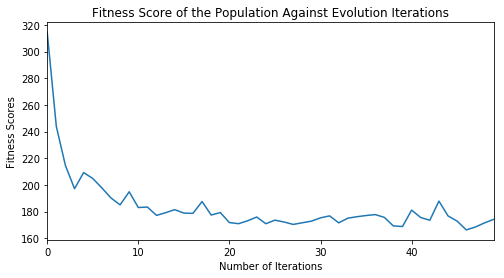

In [0]:
population_data = pd.DataFrame(data=evolution_history, columns=["Fitness Score", "Average Budgets", "Average Options"])
ax = population_data['Fitness Score']\
    .plot(
        figsize=(8, 4),
        title="Fitness Score of the Population Against Evolution Iterations")
ax.set_xlabel("Number of Iterations")
ax.set_ylabel("Fitness Scores")
plt.show()

## Visualise Average Population Spending Against \# of Iteration

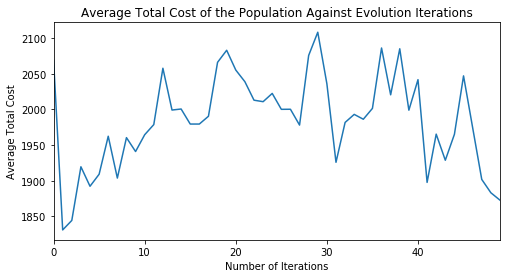

In [0]:
ax = population_data['Average Budgets']\
    .plot(
        figsize=(8, 4),
        title="Fitness Score of the Population Against Evolution Iterations")
ax.set_xlabel("Number of Iterations")
ax.set_ylabel("Average Total Budgets")
plt.show()

## Visualise Average Number of Options Against \# of Iteration

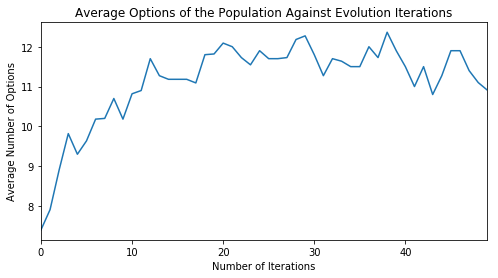

In [0]:
ax = population_data['Average Options']\
    .plot(
        figsize=(8, 4),
        title="Fitness Score of the Population Against Evolution Iterations")
ax.set_xlabel("Number of Iterations")
ax.set_ylabel("Average Number of Options")
plt.show()

##  Display options example

In [0]:
for index, x in enumerate(random.sample(population, 5)):
    print("--------------------------------------------------")
    print("Option",index+1,":")
    temp = hotels[x['h']]
    print("Hotel name: {} \nHotel star: {} \nHotel price per night: RM{}".format(temp["name"], temp["star"], temp["ppn"]))
    print("Total Hotel cost for",days_of_travel,"days --> RM", temp["ppn"] * days_of_travel,"\n")
    
    food_list = choose(food_types, x['f'])
    print("Number of food types to eat:", len(food_list))
    for i,j in enumerate(food_list):
        print("Food choice", i+1 )
        print("Food type: {} \nFood price range: RM{}-{}\n".format(j["type"], j["price"][0], 1+j["price"][-1]))
    print("Total food cost for", days_of_travel, "days --> RM", sum([(max(i['price'])+min(i['price'])) / 2 * days_of_travel for i in food_list]),"\n" )
    
    tourist_list = choose(tourist_spots, x['t'])
    print("Number of tourist spot to visit:", len(tourist_list))
    for i,j in enumerate(tourist_list):
        print("Tourist spot choice", i+1 )
        print("Place name: {} \nEntrance price: RM{}\n".format(j["name"], j["price"]))    
    print("Total tourism cost --> RM", sum([i['price'] for i in tourist_list]),"\n" )
    
    transportation_list = choose(transportations, x['r'])
    print("Number of transportation to use:", len(transportation_list))
    for i,j in enumerate(transportation_list):
        print("Transportation choice", i+1 )
        print("Transportation name: {} \nTransportation price per day: RM{}\n".format(j["name"], j["ppd"]))    
    print("Total transportation cost for", days_of_travel, "days --> RM", sum([i['ppd'] for i in transportation_list])*days_of_travel,"\n" )
    
    print("Overall total cost for option",index+1,"--> RM", total_cost_and_options(**x)[0])

--------------------------------------------------
Option 1 :
Hotel name: Sunway Velocity Hotel 
Hotel star: 3 
Hotel price per night: RM241
Total Hotel cost for 4 days --> RM 964 

Food choice 1
Food type: Malay Food 
Food price range: RM7-20

Food choice 2
Food type: Chinese Food 
Food price range: RM20-30

Food choice 3
Food type: Indian Banana Leaf 
Food price range: RM10-20

Food choice 4
Food type: Local Seafood
Food price range: RM20-30

Total food cost for 4 days --> RM 306.0 

Tourist spot choice 1
Place name: Paradise Park Farm 
Entrance price: RM63

Tourist spot choice 2
Place name: Petronas Twin Towers 
Entrance price: RM122

Tourist spot choice 3
Place name: Garden of Nature 
Entrance price: RM121

Tourist spot choice 4
Place name: Sunway Lagoon 
Entrance price: RM108

Total tourism cost --> RM 414 

Transportation choice 1
Transportation name: LRT 
Transportation price per day: RM5

Transportation choice 2
Transportation name: RapidKL Bus 
Transportation price per day: RM